# ML Training with MSD Lung RadiObject

This notebook trains a binary classifier for lung tumor detection using the Medical Segmentation Decathlon data.

## Overview

1. **Load** RadiObject from URI (S3 or local)
2. **Explore** data and label distribution
3. **Split** into train/validation sets
4. **Train** a 3D CNN classifier
5. **Evaluate** model performance

## Task

Binary classification: Predict `has_tumor` (0 or 1) from CT volume patches.

**Prerequisites:** Run [05_ingest_msd.ipynb](./05_ingest_msd.ipynb) first to create the MSD Lung RadiObject.

In [1]:
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from config import MSD_LUNG_URI, S3_REGION
from monai.transforms import Compose, NormalizeIntensityd, RandFlipd

from radiobject import RadiObject, configure
from radiobject.ctx import S3Config
from radiobject.ml import (
    create_training_dataloader,
    create_validation_dataloader,
)

print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"RadiObject URI: {MSD_LUNG_URI}")

PyTorch version: 2.10.0
NumPy version: 2.4.1
RadiObject URI: s3://souzy-scratch/msd-lung/radiobject-2mm


In [2]:
# Determine compute device
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print(f"Training device: {DEVICE}")

Training device: mps


In [3]:
# Configure S3 access if using S3 URI
if MSD_LUNG_URI.startswith("s3://"):
    configure(s3=S3Config(region=S3_REGION, max_parallel_ops=8))

TEMP_DIR = tempfile.mkdtemp(prefix="msd_ml_")
print(f"Temp directory: {TEMP_DIR}")

Temp directory: /var/folders/dj/0_0s64j55hn0gk7rrvj09zf80000gn/T/msd_ml_mk7cej9v


In [4]:
# Load RadiObject
radi = RadiObject(MSD_LUNG_URI)

# Quick summary using describe()
print(radi.describe())

RadiObject Summary
URI: s3://souzy-scratch/msd-lung/radiobject-2mm
Subjects: 63
Collections: 1

Collections:
  - CT: 63 volumes, shape=250x250x318

Label Columns:
  - has_tumor: {1: 63}
  - original_shape_x: {512: 63}
  - original_shape_y: {512: 63}


In [5]:
# Display subject metadata
obs_meta = radi.obs_meta.read()
print(f"obs_meta columns: {list(obs_meta.columns)}")
obs_meta.head(10)

obs_meta columns: ['obs_subject_id', 'obs_id', 'has_tumor', 'original_shape_x', 'original_shape_y', 'original_shape_z']


,obs_subject_id,obs_id,has_tumor,original_shape_x,original_shape_y,original_shape_z
0,lung_001,lung_001,1,512,512,304
1,lung_003,lung_003,1,512,512,288
2,lung_004,lung_004,1,512,512,276
3,lung_005,lung_005,1,512,512,329
4,lung_006,lung_006,1,512,512,567
5,lung_009,lung_009,1,512,512,301
6,lung_010,lung_010,1,512,512,241
7,lung_014,lung_014,1,512,512,589
8,lung_015,lung_015,1,512,512,277
9,lung_016,lung_016,1,512,512,228


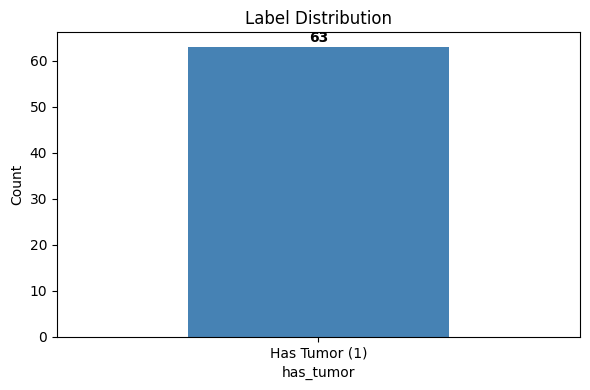

Label distribution: {1: 63}
Note: Only one class present - this is a demo dataset. Binary classification will use dummy labels.


In [6]:
# Label distribution
label_counts = obs_meta["has_tumor"].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(6, 4))
bars = label_counts.plot(kind="bar", ax=ax, color=["steelblue", "coral"][: len(label_counts)])
ax.set_xlabel("has_tumor")
ax.set_ylabel("Count")
ax.set_title("Label Distribution")

# Set tick labels based on actual labels present
tick_labels = ["Has Tumor (1)" if idx == 1 else "No Tumor (0)" for idx in label_counts.index]
ax.set_xticklabels(tick_labels, rotation=0)

for i, v in enumerate(label_counts.values):
    ax.text(i, v + 1, str(v), ha="center", fontweight="bold")

plt.tight_layout()
plt.show()

print(f"Label distribution: {label_counts.to_dict()}")
if len(label_counts) == 1:
    print(
        "Note: Only one class present - this is a demo dataset. Binary classification will use dummy labels."
    )

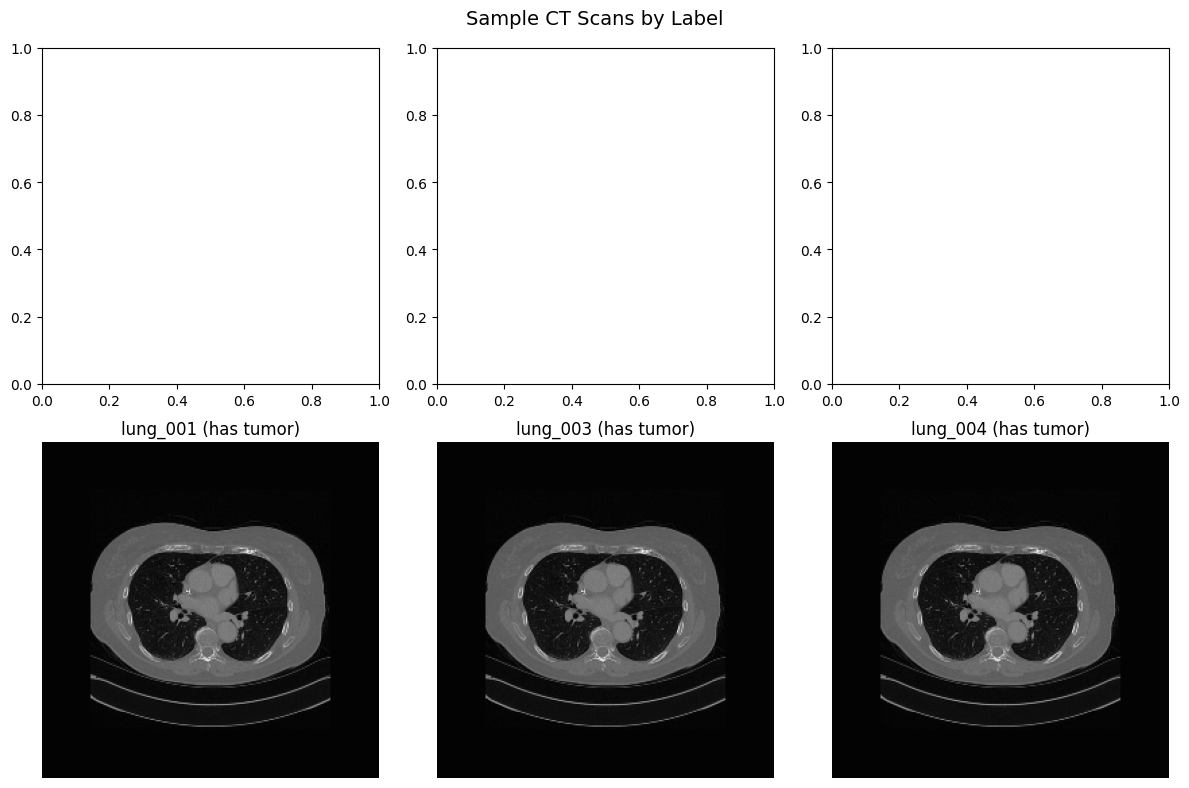

In [7]:
# Visualize samples with and without tumor
collection_name = radi.collection_names[0]
vc = radi.collection(collection_name)

# Get indices for each class
tumor_subjects = obs_meta[obs_meta["has_tumor"] == 1]["obs_subject_id"].tolist()
no_tumor_subjects = obs_meta[obs_meta["has_tumor"] == 0]["obs_subject_id"].tolist()

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# No tumor samples
for i, subject_id in enumerate(no_tumor_subjects[:3]):
    vol = radi.loc[subject_id].collection(collection_name).iloc[0]
    mid_z = vol.shape[2] // 2
    axes[0, i].imshow(vol.axial(z=mid_z).T, cmap="gray", origin="lower")
    axes[0, i].set_title(f"{subject_id} (no tumor)")
    axes[0, i].axis("off")

# Tumor samples
for i, subject_id in enumerate(tumor_subjects[:3]):
    vol = radi.loc[subject_id].collection(collection_name).iloc[0]
    mid_z = vol.shape[2] // 2
    axes[1, i].imshow(vol.axial(z=mid_z).T, cmap="gray", origin="lower")
    axes[1, i].set_title(f"{subject_id} (has tumor)")
    axes[1, i].axis("off")

plt.suptitle("Sample CT Scans by Label", fontsize=14)
plt.tight_layout()
plt.show()

In [8]:
# 80/20 stratified split
all_ids = list(radi.obs_subject_ids)
np.random.seed(42)
np.random.shuffle(all_ids)

split_idx = int(0.8 * len(all_ids))
train_ids = all_ids[:split_idx]
val_ids = all_ids[split_idx:]

print(f"Training subjects: {len(train_ids)}")
print(f"Validation subjects: {len(val_ids)}")

# Check label distribution in splits
train_labels = obs_meta[obs_meta["obs_subject_id"].isin(train_ids)]["has_tumor"]
val_labels = obs_meta[obs_meta["obs_subject_id"].isin(val_ids)]["has_tumor"]

print(f"\nTrain label distribution: {train_labels.value_counts().to_dict()}")
print(f"Val label distribution: {val_labels.value_counts().to_dict()}")

Training subjects: 50
Validation subjects: 13

Train label distribution: {1: 50}
Val label distribution: {1: 13}


In [9]:
# Create train/val RadiObjects
train_uri = f"{TEMP_DIR}/train_radi"
val_uri = f"{TEMP_DIR}/val_radi"

radi_train = radi.loc[train_ids].to_radi_object(train_uri)
radi_val = radi.loc[val_ids].to_radi_object(val_uri)

print(f"Train RadiObject: {radi_train}")
print(f"Val RadiObject: {radi_val}")

Train RadiObject: RadiObject(50 subjects, 1 collections: [CT])
Val RadiObject: RadiObject(13 subjects, 1 collections: [CT])


In [10]:
# Training hyperparameters
BATCH_SIZE = 4
PATCH_SIZE = (64, 64, 64)

# Define transforms using MONAI dict transforms
# These work directly with RadiObjectDataset output format
train_transform = Compose(
    [
        NormalizeIntensityd(keys="image", channel_wise=True),
        RandFlipd(keys="image", prob=0.5, spatial_axis=[0, 1, 2]),
    ]
)

val_transform = Compose(
    [
        NormalizeIntensityd(keys="image", channel_wise=True),
    ]
)

# Create dataloaders using the new API
train_loader = create_training_dataloader(
    radi_train,
    modalities=[radi.collection_names[0]],
    label_column="has_tumor",
    batch_size=BATCH_SIZE,
    patch_size=PATCH_SIZE,
    num_workers=0,
    pin_memory=False,
    persistent_workers=False,
    transform=train_transform,
)

# Use create_validation_dataloader for val set (no shuffle, no drop_last)
val_loader = create_validation_dataloader(
    radi_val,
    modalities=[radi.collection_names[0]],
    label_column="has_tumor",
    batch_size=BATCH_SIZE,
    patch_size=PATCH_SIZE,
    num_workers=0,
    pin_memory=False,
    transform=val_transform,
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Train transform: {train_transform}")
print(f"Val transform: {val_transform}")

Train batches: 12
Val batches: 4
Train transform: <monai.transforms.compose.Compose object at 0x11855e750>
Val transform: <monai.transforms.compose.Compose object at 0x11853c610>


In [11]:
# Inspect a batch
batch = next(iter(train_loader))

print(f"Batch keys: {list(batch.keys())}")
print(f"Image shape: {batch['image'].shape}")  # (B, C, D, H, W)
print(f"Image dtype: {batch['image'].dtype}")
print(f"Labels: {batch['label'].tolist()}")
print(f"Memory per batch: {batch['image'].nbytes / 1024 / 1024:.1f} MB")

Batch keys: ['image', 'idx', 'patch_idx', 'patch_start', 'label']
Image shape: torch.Size([4, 1, 64, 64, 64])
Image dtype: torch.float32
Labels: [1, 1, 1, 1]
Memory per batch: 4.0 MB


In [12]:
class Simple3DCNN(nn.Module):
    """3D CNN for binary classification."""

    def __init__(self, in_channels: int = 1, num_classes: int = 2):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(64)
        self.pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool3d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool3d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x).flatten(1)
        return self.fc(x)


model = Simple3DCNN(in_channels=1, num_classes=2).to(DEVICE)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 70,018


In [13]:
# Training configuration
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Training history
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

In [14]:
print(f"Training on {DEVICE} for {NUM_EPOCHS} epochs...\n")

for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for batch in train_loader:
        images = batch["image"].to(DEVICE)
        labels = batch["label"].long().to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()
        train_total += labels.size(0)

    # Validation phase
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(DEVICE)
            labels = batch["label"].long().to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += labels.size(0)

    # Record metrics
    history["train_loss"].append(train_loss / len(train_loader))
    history["train_acc"].append(100.0 * train_correct / train_total)
    history["val_loss"].append(val_loss / len(val_loader))
    history["val_acc"].append(100.0 * val_correct / val_total)

    print(
        f"Epoch {epoch + 1:2d}/{NUM_EPOCHS}: "
        f"Train Loss={history['train_loss'][-1]:.4f}, "
        f"Train Acc={history['train_acc'][-1]:.1f}%, "
        f"Val Loss={history['val_loss'][-1]:.4f}, "
        f"Val Acc={history['val_acc'][-1]:.1f}%"
    )

Training on mps for 10 epochs...



Epoch  1/10: Train Loss=0.5129, Train Acc=91.7%, Val Loss=0.3534, Val Acc=100.0%


Epoch  2/10: Train Loss=0.2694, Train Acc=100.0%, Val Loss=0.2257, Val Acc=100.0%


Epoch  3/10: Train Loss=0.1511, Train Acc=100.0%, Val Loss=0.1311, Val Acc=100.0%


Epoch  4/10: Train Loss=0.0979, Train Acc=100.0%, Val Loss=0.1237, Val Acc=100.0%


Epoch  5/10: Train Loss=0.0689, Train Acc=100.0%, Val Loss=0.0627, Val Acc=100.0%


Epoch  6/10: Train Loss=0.0525, Train Acc=100.0%, Val Loss=0.0570, Val Acc=100.0%


Epoch  7/10: Train Loss=0.0388, Train Acc=100.0%, Val Loss=0.0412, Val Acc=100.0%


Epoch  8/10: Train Loss=0.0313, Train Acc=100.0%, Val Loss=0.0253, Val Acc=100.0%


Epoch  9/10: Train Loss=0.0248, Train Acc=100.0%, Val Loss=0.0227, Val Acc=100.0%


Epoch 10/10: Train Loss=0.0204, Train Acc=100.0%, Val Loss=0.0245, Val Acc=100.0%


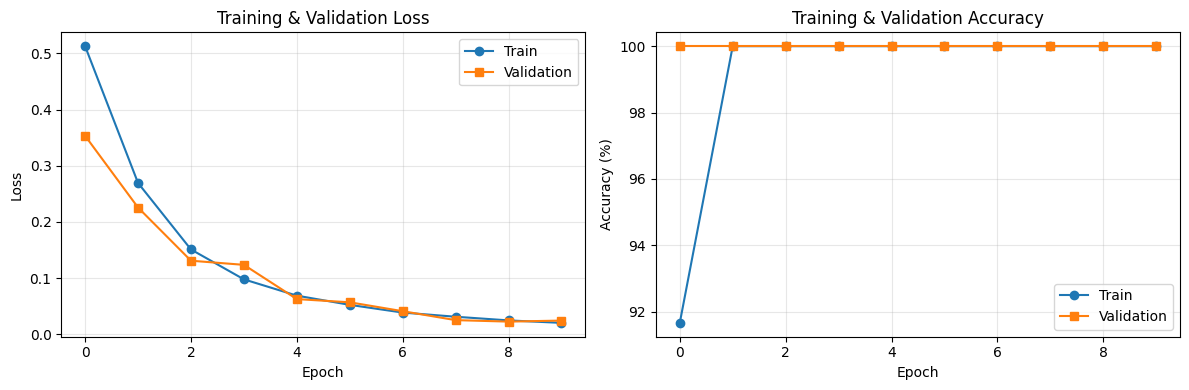

In [15]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history["train_loss"], marker="o", label="Train")
axes[0].plot(history["val_loss"], marker="s", label="Validation")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training & Validation Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history["train_acc"], marker="o", label="Train")
axes[1].plot(history["val_acc"], marker="s", label="Validation")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Training & Validation Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Final metrics
print("=" * 40)
print("Final Results")
print("=" * 40)
print(f"Best Train Accuracy: {max(history['train_acc']):.1f}%")
print(f"Best Val Accuracy: {max(history['val_acc']):.1f}%")
print(f"Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Val Loss: {history['val_loss'][-1]:.4f}")

Final Results
Best Train Accuracy: 100.0%
Best Val Accuracy: 100.0%
Final Train Loss: 0.0204
Final Val Loss: 0.0245


In [17]:
# Cleanup temporary directory
shutil.rmtree(TEMP_DIR)
print(f"Cleaned up: {TEMP_DIR}")

Cleaned up: /var/folders/dj/0_0s64j55hn0gk7rrvj09zf80000gn/T/msd_ml_mk7cej9v
